In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

# Load required packages

In [3]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scvelo as scv
import scanpy as sc
import seaborn as sns
import torch
import gc
import importlib

In [4]:
import torch.nn.functional as F

In [5]:
import scvi
scvi.settings.seed = 0

Global seed set to 0


# Load neural networks classes for noSpliceVelo

In [6]:
# Add path to src
import sys
dir_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(dir_path)

In [7]:
import scvi_modified_capture_efficiency_model
import nosplicevelo_model
import utils_RNA_velocity

In [8]:
importlib.reload(scvi_modified_capture_efficiency_model)
importlib.reload(nosplicevelo_model)
importlib.reload(utils_RNA_velocity)

<module 'utils_RNA_velocity' from '/media/atheistpoet/TarunHDD/maslov_lab/code/noSpliceVelo/src/utils_RNA_velocity.py'>

In [9]:
from scvi_modified_capture_efficiency_model import SCVIModified
from nosplicevelo_model import noSpliceVelo
from utils_RNA_velocity import get_nosplicevelo_ll_params

# load pancreas dataset
For your data, first perform pre-processing as suggested by [scvi-tools](https://docs.scvi-tools.org/en/stable/)

## get data from scVelo with spliced and unspliced counts

In [10]:
# load data
adata = scv.datasets.pancreas()

In [11]:
# make a copy to use for modeling total count with noSpliceVelo
adata_pan = adata.copy()

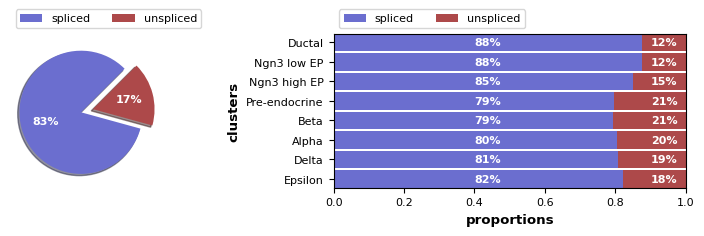

In [12]:
# plot proportion of spliced/unspliced counts
scv.pl.proportions(adata)

In [13]:
# filtering and normalization
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [33]:
# load pancreas data already processed and with velocities
# anndata object available at Mahajan, Tarun (2024). adata_pancrease_nosplicevelo.h5ad. 
# figshare. Dataset. https://doi.org/10.6084/m9.figshare.27021841.v1
dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', \
                                        "data",\
                                        "pancreas_endocrinogenesis"))
os.makedirs(dir_path, exist_ok=True)
filname = os.path.join(dir_path, \
                       f'adata_pancrease_nosplicevelo' + \
                       f'.h5ad')
adata_pan = ad.read_h5ad(filname)

In [34]:
# delete previously compute velocities and associated mu and var. 
# We will perform the entire analysis again
del adata_pan.layers['mu_geneCell'], adata_pan.layers['mu_gene']
del adata_pan.layers['velocity_geneCell'], adata_pan.layers['velocity_gene']
del adata_pan.layers['var_geneCell'], adata_pan.layers['var_gene']
del adata_pan.layers['velocity_var_geneCell'], adata_pan.layers['velocity_var_gene']
del adata_pan.layers['mu'], adata_pan.layers['std']

In [35]:
adata_pan

AnnData object with n_obs × n_vars = 3696 × 991
    obs: 'capture_efficiency', 'cell_id', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'log_counts', 'mu_unsmooth', 'prior_clusters', 'std_unsmooth'
    obsp: 'connectivities', 'distances'

In [14]:
adata_pan  = adata_pan[adata.obs_names, :].copy()

In [15]:
## Preprocess data

In [16]:
adata_pan.var_names

Index(['Xkr4', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Rgs20', 'Npbwr1', '4732440D04Rik',
       ...
       'Gm28406', 'Gm29436', 'Gm28407', 'Gm29393', 'Gm21294', 'Gm28672',
       'Gm28670', 'Gm29504', 'Gm20837', 'Erdr1'],
      dtype='object', name='index', length=27998)

In [17]:
# remove mitochondrial genes
genes_not_mt = np.where(~adata_pan.var_names.str.startswith('mt-') == True)[0]
adata_pan = adata_pan[:, genes_not_mt].copy()

In [18]:
sc.pp.filter_genes(adata_pan, min_counts=3)

In [19]:
adata_pan.layers['counts'] = adata_pan.X.copy()


In [20]:
sc.pp.normalize_total(adata_pan, target_sum=1e4)
sc.pp.log1p(adata_pan)
adata_pan.layers['log_counts'] = adata_pan.X.copy()

In [21]:
adata_pan_copy = adata_pan.copy()

In [22]:
# get dispersion values for all genes, but do not subet by highly variable genes (HVGs)
sc.pp.highly_variable_genes(
    adata_pan_copy,
    n_top_genes=2000,
    subset=False,
    layer="log_counts",
    flavor="seurat",
)

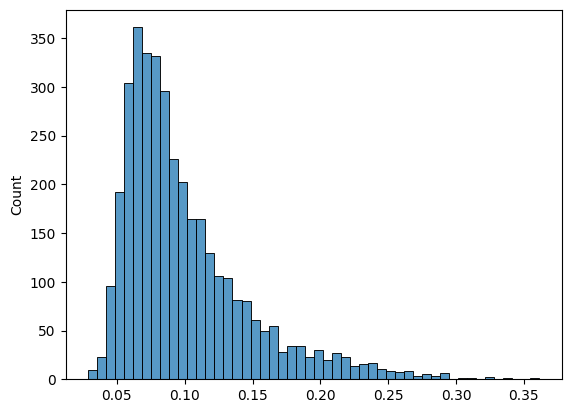

In [23]:
# get capture efficiency based on lowly variable genes (LVG)
num_genes = 5000
id_order_LVG = np.argsort(adata_pan_copy.var['dispersions'].values)[:num_genes]
capture_eff = np.array(adata_pan_copy.layers['counts'][:, id_order_LVG].sum(axis=1)).flatten()
capture_eff /= np.mean(capture_eff)
capture_eff *= 0.1
plt_ = sns.histplot(capture_eff, bins=50)

In [24]:
del adata_pan_copy

In [25]:
adata_pan.obs['capture_efficiency'] = capture_eff

In [26]:
# keep only highly variable genes (HVGs)
sc.pp.highly_variable_genes(
    adata_pan,
    n_top_genes=2000,
    subset=True,
    layer="log_counts",
    flavor="seurat",
)

In [27]:
adata_pan

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'capture_efficiency'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts', 'log_counts'
    obsp: 'distances', 'connectivities'

# First process the data with the first VAE, which is a modified scvi


In [28]:
device_ = "cuda" if torch.cuda.is_available() else "cpu"
# device_ = "cpu"

In [29]:
# setup adata_pan for SCVIModified
SCVIModified.setup_anndata(
    adata_pan,
    layer="counts",
    size_factor_key='capture_efficiency'
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [30]:
# create model object for SCVIModified
fac_loss_noise = 1e-5 # to regularize variability in burst size across cells
model_scvi = SCVIModified(adata_pan, burst_B_gene=False, \
                            var_activation=F.softplus, device_=device_, \
                            n_hidden=128, n_latent=10, log_variational=True, \
                            fac_loss_noise=fac_loss_noise)

In [31]:
# train the model
model_scvi.train(max_epochs=10000, batch_size=512, \
                 train_size=0.9, validation_size=0.1, early_stopping=True, \
                 early_stopping_patience=100, \
                 early_stopping_monitor='elbo_validation')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3/10000:   0%|          | 2/10000 [00:00<41:09,  4.05it/s, v_num=1, train_loss_step=2.49e+3, train_loss_epoch=2.61e+3]  

/home/atheistpoet/anaconda3/envs/noSpliceVelo_env_gpu/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/atheistpoet/anaconda3/envs/noSpliceVelo_env_gpu/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
/home/atheistpoet/anaconda3/envs/noSpliceVelo_env_gpu/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)


Epoch 1665/10000:  17%|█▋        | 1665/10000 [03:23<16:59,  8.18it/s, v_num=1, train_loss_step=800, train_loss_epoch=798]    
Monitored metric elbo_validation did not improve in the last 100 records. Best score: 812.864. Signaling Trainer to stop.


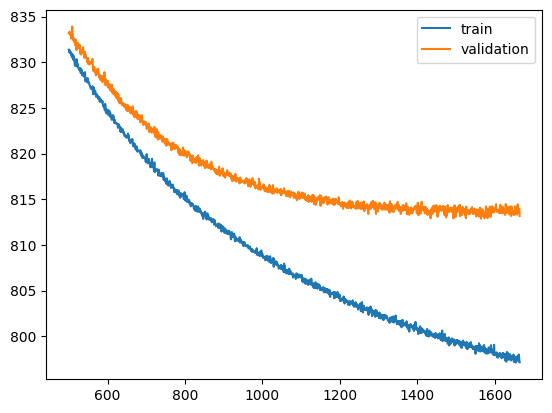

In [32]:
# plot train and validation error
y1 = model_scvi.history['elbo_train']['elbo_train'].values
y2 = model_scvi.history['elbo_validation']['elbo_validation'].values
y = np.hstack((y1, y2))
x = np.hstack((np.arange(len(y1)), np.arange(len(y1))))
z = np.array(['train'] * len(y1) + ['validation'] * len(y2), dtype=object)
id_ = np.where(x >= 500)
plt_ = sns.lineplot(x=x[id_], y=y[id_], hue=z[id_], hue_order=['train', 'validation'])

In [51]:
# save the trained model
dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', "data", "pancreas_endocrinogenesis"))
# Check if the directory does not exist
if not os.path.exists(dir_path):
    # Create the directory
    os.makedirs(dir_path)
today_ = "20240925" # use current date
filname = os.path.join(dir_path, \
                       f'{today_}_model_scvi_modified_regNoise1Eneg5_pancreas_example.pt')
model_scvi.save(filname, overwrite=True, save_anndata=True)

In [33]:
# get gene-cell specific estimates of mean and variance of expression estimated by SCVIModified
nrepeats = 10 # nume samples for posterior predictive estimate
for n_ in range(nrepeats):
    print(f'repeat = {n_}')
    params_scvi = model_scvi.get_likelihood_parameters_new()
    mu_tmp = params_scvi['mu'].copy()
    var_tmp = params_scvi['var'].copy()

    if n_ == 0:
        mu_scvi = mu_tmp.copy()
        var_scvi = var_tmp.copy()
    else:
        mu_scvi += mu_tmp.copy()
        var_scvi += var_tmp.copy()
    torch.cuda.empty_cache()
    gc.collect()
mu_scvi /= nrepeats
var_scvi /= nrepeats

repeat = 0
repeat = 1
repeat = 2
repeat = 3
repeat = 4
repeat = 5
repeat = 6
repeat = 7
repeat = 8
repeat = 9


In [53]:
# smoothen the gene-cell estimates of mean and variance using knn in the latent space of SCVIModified
z_latent = model_scvi.get_latent_representation()
n_nbers = 30
mu_scvi_smooth = np.zeros_like(mu_scvi)
var_scvi_smooth = np.zeros_like(var_scvi)
for cell_ in np.arange(adata_pan.shape[0]):
    dist_z = ((z_latent[cell_, :] - z_latent)**2.0).sum(1)
    id_cells = np.argsort(dist_z)[:(n_nbers + 1)]
    mu_scvi_smooth[cell_, :] = np.mean(mu_scvi[id_cells, :], axis=0)
    var_scvi_smooth[cell_, :] = np.mean(var_scvi[id_cells, :], axis=0)

In [54]:
# save gene-cell estimates of mean and variance of expression and their smoothened values
import pickle
today_ = "20240915" # use current date
dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', "data", "pancreas_endocrinogenesis"))
# Check if the directory does not exist
if not os.path.exists(dir_path):
    # Create the directory
    os.makedirs(dir_path)
filname = os.path.join(dir_path, \
                       f'{today_}_model_scvi_modified_posteriorParams_' + \
                       f'regNoise1Eneg5_pancreas_example.pkl')
params_scvi_dict = {}
params_scvi_dict['mu'] = mu_scvi.copy()
params_scvi_dict['var'] = var_scvi.copy()
params_scvi_dict['mu_smooth'] = mu_scvi_smooth.copy()
params_scvi_dict['var_smooth'] = var_scvi_smooth.copy()
with open(filname, 'wb') as f:
    pickle.dump(params_scvi_dict, f)

## check variance vs mean phase plots for individual genes

### gene Ppp3ca

Text(0.5, 1.0, 'Ppp3ca')

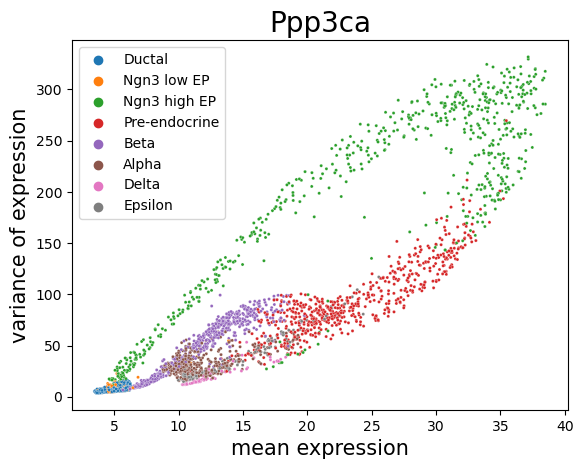

In [55]:
# check variance vs mean phase plots for individual genes
gene_ensb = "ENSMUSG00000028161" # Ppp3ca
gene_name = "Ppp3ca"
gene_ = np.where(adata_pan.var_names == gene_ensb)[0][0]

x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
# x = mu_scvi[:, gene_].copy()
# y = var_scvi[:, gene_].copy()
x_max = np.max(x)
y_max = np.max(y)

z = adata.obs['clusters'].values.copy()
plt_ = sns.scatterplot(x=x, y=(y), hue=z, s=5)
plt_.set_xlabel("mean expression", fontsize=15)
plt_.set_ylabel("variance of expression", fontsize=15)
plt_.set_title(f'{gene_name}', fontsize=20)


### gene Map1b

Text(0.5, 1.0, 'Map1b')

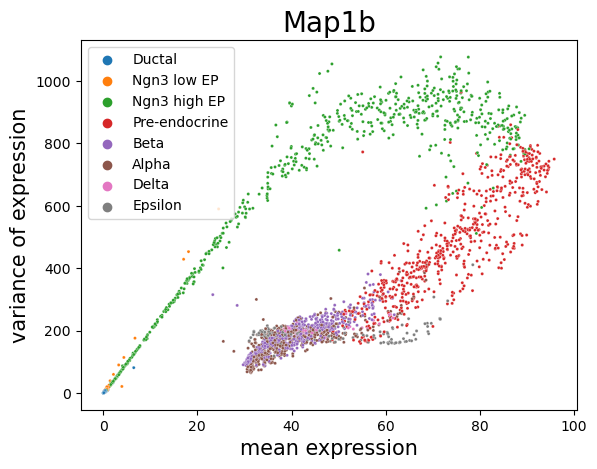

In [56]:
# check variance vs mean phase plots for individual genes
gene_ensb = "ENSMUSG00000052727" # Ppp3ca
gene_name = "Map1b"
gene_ = np.where(adata_pan.var_names == gene_ensb)[0][0]

x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
# x = mu_scvi[:, gene_].copy()
# y = var_scvi[:, gene_].copy()
x_max = np.max(x)
y_max = np.max(y)

z = adata.obs['clusters'].values.copy()
plt_ = sns.scatterplot(x=x, y=(y), hue=z, s=5)
plt_.set_xlabel("mean expression", fontsize=15)
plt_.set_ylabel("variance of expression", fontsize=15)
plt_.set_title(f'{gene_name}', fontsize=20)


In [58]:
torch.cuda.empty_cache()
gc.collect()

0

# Next, perform analysis with noSpliceVelo to get velocity

## Setup data for analysis

### create new anndata object

In [59]:
adata_pan_velo = adata_pan.copy()
adata_pan_velo.layers['mu'] = mu_scvi_smooth.copy()
adata_pan_velo.layers['std'] = np.sqrt(var_scvi_smooth.copy())
adata_pan_velo.layers['prior_clusters'] = np.ones(adata_pan_velo.shape)


In [60]:
device_ = "cpu"

### get max values of var across genes
These will be used to compute reflected standard deviation of expression given by $\sigma_{\text{ref}} = \sqrt{\sigma^2_{\text{max}} - \sigma^2}$. All intermediate variance params for noSpliceVelo will clamped to be less than or equal to these max values. Therefore, $\sigma^2_{\text{max}}$ is set equal to $5$ times of the observed max values. This allows the model consider situations where genes swtich from upregulation to downregulation before reaching the steady state.

In [61]:
fac_multiply = 5.0
fac_var = fac_multiply
mu_max = np.max(mu_scvi_smooth, axis=0) * fac_multiply + 1
var_max = np.max(var_scvi_smooth, axis=0) * fac_multiply + 1
mu_max_torch = torch.tensor(mu_max, dtype=torch.float, device=device_)
var_max_torch = torch.tensor(var_max, dtype=torch.float, device=device_)

### compute scale var_scvi_smooth and mu_scvi_smooth
We compute scale (observed gene-specific max values) for mean, standard deviation and reflected standard deviation of expression

In [70]:
ac_multiply = 1.0
mu_scale = np.max(mu_scvi_smooth * fac_multiply, axis=0)
std_scale = np.max(np.sqrt(var_scvi_smooth * fac_multiply), axis=0)
std_ref_scale = np.max(np.sqrt(var_max - var_scvi_smooth * fac_multiply), axis=0)

mu_center = np.mean(mu_scvi_smooth * fac_multiply, axis=0)
std_center = np.mean(np.sqrt(var_scvi_smooth * fac_multiply), axis=0)
std_ref_center = np.mean(np.sqrt(var_max - var_scvi_smooth * fac_multiply), axis=0)

mu_scale = torch.tensor(mu_scale, dtype=torch.float, device=device_)
std_scale = torch.tensor(std_scale, dtype=torch.float, device=device_)
std_ref_scale = torch.tensor(std_ref_scale, dtype=torch.float, device=device_)

mu_center = torch.tensor(mu_center, dtype=torch.float, device=device_)
std_center = torch.tensor(std_center, dtype=torch.float, device=device_)
std_ref_center = torch.tensor(std_ref_center, dtype=torch.float, device=device_)

mu_center[:] = 0.0
std_center[:] = 0.0
std_ref_center[:] = 0.0

In [71]:
std_sum = ((2 * np.sqrt(var_scvi_smooth * fac_multiply + 1e-10))**2.0).mean(0)
std_sum = np.sqrt(std_sum + 1e-10)
std_sum_torch = torch.tensor(std_sum, dtype=torch.float, device=device_)

### Estimate observed mean and variances at the corners

In [74]:
mu_cornerMu_obs = np.zeros(adata_pan_velo.shape[1])
var_cornerMu_obs = np.zeros(adata_pan_velo.shape[1])
quantile_ = 0.95
for gene_ in np.arange(adata_pan_velo.shape[1]):
    id_ = np.where(mu_scvi_smooth[:, gene_] >= \
                   np.quantile(mu_scvi_smooth[:, gene_], quantile_))[0]
    mu_cornerMu_obs[gene_] = np.mean(mu_scvi_smooth[id_, gene_])
    var_cornerMu_obs[gene_] = np.mean(var_scvi_smooth[id_, gene_])
mu_cornerMu_obs = torch.tensor(mu_cornerMu_obs, dtype=torch.float, device=device_)
var_cornerMu_obs = torch.tensor(var_cornerMu_obs, dtype=torch.float, device=device_)

mu_cornerVar_obs = np.zeros(adata_pan_velo.shape[1])
var_cornerVar_obs = np.zeros(adata_pan_velo.shape[1])
for gene_ in np.arange(adata_pan_velo.shape[1]):
    id_ = np.where((var_scvi_smooth[:, gene_] >= \
                    np.quantile(var_scvi_smooth[:, gene_], quantile_)))
    mu_cornerVar_obs[gene_] = np.mean(mu_scvi_smooth[id_, gene_])
    var_cornerVar_obs[gene_] = np.mean(var_scvi_smooth[id_, gene_])
mu_cornerVar_obs = torch.tensor(mu_cornerVar_obs, dtype=torch.float, device=device_)
var_cornerVar_obs = torch.tensor(var_cornerVar_obs, dtype=torch.float, device=device_)

## Perform analysis with noSpliceVelo

### Setup data for noSpliceVelo

In [80]:
noSpliceVelo.setup_anndata(    
    adata_pan_velo, 
    layer='counts', 
    continuous_covariate_keys=['capture_efficiency'],
    mean_layer='mu', 
    std_layer='std',
    prior_cluster='prior_clusters',
)

### Create noSpliceVelo model object

In [82]:
# first gene-specific, and then gene-cell specific
loss_fac_geneCell = 1.0
loss_fac_gene = 1.0
loss_ = 0.1
loss_0 = 0.1
loss_1 = 0.1
loss_2 = 0.1
loss_prior_cluster = 0.0
match_upf_down_up = False
match_burst_params = True
model_nosplicevelo = noSpliceVelo(adata_pan_velo, dispersion='gene-cell', \
                                gene_likelihood='nb', \
                                tmax=24, var_activation=F.softplus, 
                                log_variational=False, \
                                n_states=2, n_hidden=128, \
                                n_latent=10, cluster_states=False, \
                                burst_B_gene=True, burst_f_gene=True, \
                                use_loss_burst=False, use_controlBurst_gene=True, \
                                use_time_cell=False, state_times_unique=None, \
                                burst_f_updown=None, \
                                burst_B_updown=None, \
                                burst_f_next=None, \
                                burst_B_next=None, \
                                burst_f_updown_next=None, \
                                burst_B_updown_next=None, mu_max=mu_max_torch, \
                                var_max=var_max_torch, std_sum=std_sum_torch, \
                                match_burst_params=match_burst_params, match_upf_down_up=match_upf_down_up, \
                                match_burst_params_not_muVar=False,
                                extra_loss_fac_0=loss_0, \
                                extra_loss_fac=loss_, extra_loss_fac_1=loss_1, \
                                extra_loss_fac_2=loss_2,
                                mu_center=mu_center, mu_scale=mu_scale,
                                std_center=std_center, std_scale=std_scale, \
                                std_ref_center=std_ref_center, std_ref_scale=std_ref_scale, \
                                loss_fac_geneCell=loss_fac_geneCell, loss_fac_gene=loss_fac_gene, \
                                mu_ss_obs=mu_cornerVar_obs, var_ss_obs=var_cornerVar_obs, \
                                mu_mean_obs=mu_cornerMu_obs, var_mean_obs=var_cornerMu_obs, \
                                loss_fac_prior_clust=loss_prior_cluster)

### Train the model
We highly recommend training with a cuda-enabled GPU. The different scales across genes, and especially genes with large variance of expression can slow down the training. Further, we also need to set the ```early_stopping_patience``` to a large valu, $1500$ here, to avoid local fluctations in training. We empirically found that for this dataset, training the model for roughly 40000 to 50000 epochs gives the best results.

In [85]:
model_nosplicevelo.train(max_epochs=100000, batch_size=512, train_size=0.9, \
                     validation_size=0.1, 
                     early_stopping=True, \
                     early_stopping_patience=1500, \
                     early_stopping_monitor='elbo_validation')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 149/100000:   0%|          | 148/100000 [08:41<108:39:24,  3.92s/it, loss=-2.12e+03, v_num=1]

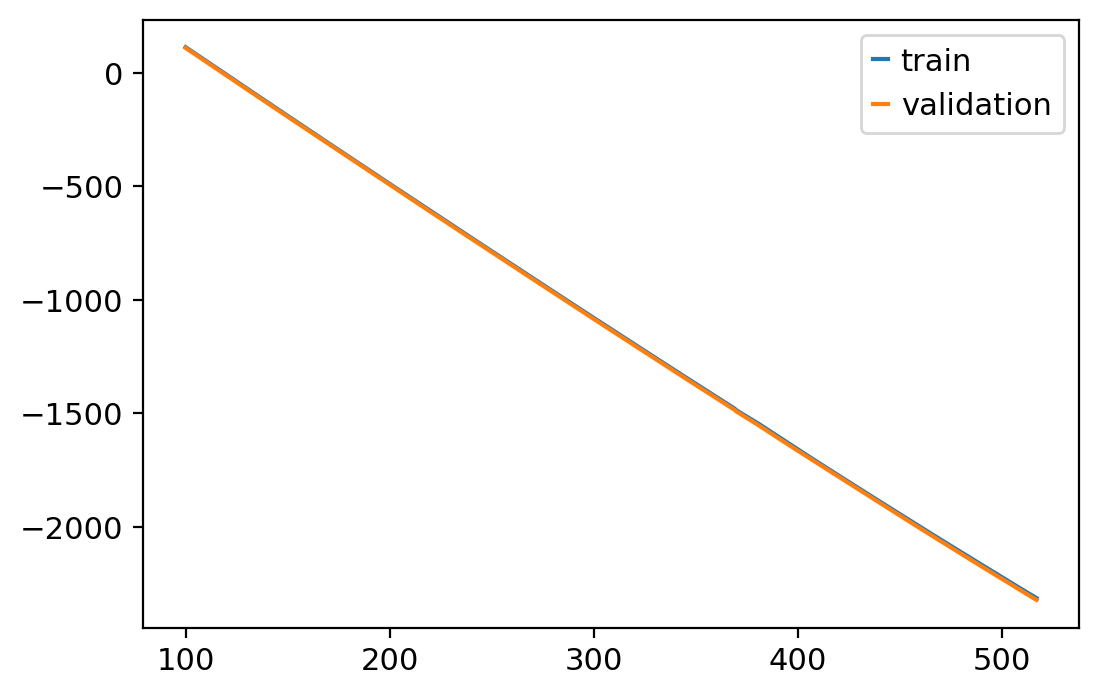

In [86]:
# plot train and validation error
y1 = model_nosplicevelo.history['elbo_train']['elbo_train'].values
y2 = model_nosplicevelo.history['elbo_validation']['elbo_validation'].values
y = np.hstack((y1, y2))
x = np.hstack((np.arange(len(y1)), np.arange(len(y1))))
z = np.array(['train'] * len(y1) + ['validation'] * len(y2), dtype=object)
id_ = np.where(x >= 100)
plt_ = sns.lineplot(x=x[id_], y=y[id_], hue=z[id_], hue_order=['train', 'validation'])

In [87]:
# save the trained model
today_ = "20240915" # use current date
dir_path = os.path.abspath(os.path.join(os.getcwd(), "data", "nosplice_velocity", \
                                        "pancreas_endocrinogenesis"))
filname = os.path.join(dir_path, \
                       f'{today_}_model_nosplicevelo_pancreas_example.pt')
model_nosplicevelo.save(filname, overwrite=True, save_anndata=True)

In [88]:
torch.cuda.empty_cache()
gc.collect()

7746

In [16]:
# save the trained model
today_ = "20240915" # use current date
dir_path = os.path.abspath(os.path.join(os.getcwd(), "data", "nosplice_velocity", \
                                        "pancreas_endocrinogenesis"))
filname = os.path.join(dir_path, \
                       f'{today_}_model_nosplicevelo_pancreas_example.pt')
model_nosplicevelo = noSpliceVelo.load(filname)
adata_pan_velo = model_nosplicevelo.adata.copy()
mu_scvi_smooth = adata_pan_velo.layers['mu'].copy()
var_scvi_smooth = adata_pan_velo.layers['std'].copy()**2.0

INFO     File                                                                                                      
         /home/tarunm3/Desktop/work/maslov_lab/code/noSpliceVelo/notebooks/data/nosplice_velocity/pancreas_endocrin
         ogenesis/20240915_model_nosplicevelo_pancreas_example.pt/model.pt already downloaded                      


### Get posterior predictive params for mu and var
We estimate the initial and final steady states for the upregulated and downregulated branches of gene expression. We sample from the posterios distribution `nboot = 10` times, and take the average as the estimate.

In [89]:
params_all = get_nosplicevelo_ll_params(model_nosplicevelo, nboot=10, prob_thresh=0.5)

gene boot = 0
gene boot = 1
gene boot = 2
gene boot = 3
gene boot = 4
gene boot = 5
gene boot = 6
gene boot = 7
gene boot = 8
gene boot = 9
gene-cell boot = 0
gene-cell boot = 1
gene-cell boot = 2
gene-cell boot = 3
gene-cell boot = 4
gene-cell boot = 5
gene-cell boot = 6
gene-cell boot = 7
gene-cell boot = 8
gene-cell boot = 9


In [90]:
mu_nosplicevelo = params_all['mu_all'].copy() # fitted mu, gene-cell
var_nosplicevelo = params_all['var_all'].copy() # fitted var, gene-cell
velo_mu_nosplicevelo = params_all['velo_mu_all'].copy() # fitted velocity for mu, gene-cell
velo_var_nosplicevelo = params_all['velo_var_all'].copy() # fitted velocity for var, gene-cell
time_pred = params_all['time_pred_all'].copy() # fitted time
probs_all = params_all['probs_all'].copy() # probability of belonging to the upregulated branch

mu_nosplicevelo_gene = params_all['mu_all_gene'].copy() # fitted mu, gene
var_nosplicevelo_gene = params_all['var_all_gene'].copy() # fitted var, gene
velo_mu_nosplicevelo_gene = params_all['velo_mu_all_gene'].copy() # fitted velocity for mu, gene
velo_var_nosplicevelo_gene = params_all['velo_var_all_gene'].copy() # fitted velocity for var, gene

In [91]:
torch.cuda.empty_cache()
gc.collect()

0

In [92]:
from utils_RNA_velocity import get_nosplicevelo_ll_params_muVarUp_gene
mu_up_f_gene, var_up_f_gene, \
    mu_down_up_gene, var_down_up_gene = \
        get_nosplicevelo_ll_params_muVarUp_gene(model_nosplicevelo, nboot=10, prob_thresh=0.5)

gene boot = 0
gene boot = 1
gene boot = 2
gene boot = 3
gene boot = 4
gene boot = 5
gene boot = 6
gene boot = 7
gene boot = 8
gene boot = 9


In [93]:
adata = adata[adata_pan_velo.obs_names, :].copy()

### Get paramters for the upregulated and downregulated branches
These are used to generate parabolic fits for the upregulated and downregulated branches


In [94]:
# get gene-cell specific velo from gene-cell specific params
# test velocity for super
def get_mu_var_time(mu_0, var_0, mu_f, var_f, gamma_, time):
    p_t = np.exp(-gamma_ * time)
    mu_t = mu_0 * p_t + mu_f * (1 - p_t)
    var_t = (var_0 - mu_0) * p_t**2.0 + (var_f - mu_f) * (1 - p_t**2.0) + mu_t
    return mu_t, var_t

def get_new_time(mu_0, var_0, mu_f, var_f, mu_t, var_t, gamma_):
    mu_ratio = (mu_t - mu_0) / (mu_f - mu_0)
    mu_ratio = np.clip(mu_ratio, a_min=0, a_max=1)
    time_mu = - (np.log(1 - mu_ratio) / gamma_)
    var_ratio = (((var_f - mu_f) - (var_0 - mu_0))) / ((var_f - mu_f) - (var_t - mu_t))
    time_var = - (np.log(var_ratio)) / gamma_
    return time_mu, time_var

params_nosplicevelo = model_nosplicevelo.get_likelihood_parameters_new()
params_nosplicevelo.keys()

velo_mu_up = params_nosplicevelo['velo_mu_up'].copy()
velo_var_up = params_nosplicevelo['velo_var_up'].copy()
velo_mu_down = params_nosplicevelo['velo_mu_down'].copy()
velo_var_down = params_nosplicevelo['velo_var_down'].copy()
f1 = params_nosplicevelo['burst_f1'].copy()
b1 = params_nosplicevelo['burst_B1'].copy()
gamma_ = params_nosplicevelo['gamma_mRNA_all'].copy()
mu_0 = f1 * b1 / gamma_
var_0 = mu_0 * (b1 + 1)
mu_up_f = params_nosplicevelo['mu_up_f'].copy()
var_up_f = params_nosplicevelo['var_up_f'].copy()
mu_down_up = params_nosplicevelo['mu_down_up'].copy()
var_down_up = params_nosplicevelo['var_down_up'].copy()
mu_down_f = params_nosplicevelo['mu_down_f'].copy()
var_down_f = params_nosplicevelo['var_down_f'].copy()
time_up = params_nosplicevelo['tau_up'].copy()
time_down = params_nosplicevelo['tau_down'].copy()
time_ss = params_nosplicevelo['time_ss'].copy()
mu_up, var_up = get_mu_var_time(mu_0, var_0, mu_up_f, var_up_f, gamma_, time_up)
mu_down, var_down = get_mu_var_time(mu_down_up, var_down_up, \
                                    mu_down_f, var_down_f, gamma_, time_down)
gamma_ = params_nosplicevelo['gamma_mRNA_all'].copy()

probs_ = params_nosplicevelo['prob_state_list'][:, :, 0].copy()
probs_1 = 1 - probs_.copy()
prob_thresh = 0.5
id_up = np.where(probs_ >= prob_thresh)
id_down = np.where(probs_ < (1 - prob_thresh))
id_mid = np.where((probs_ > (1 - prob_thresh)) & (probs_ < prob_thresh))

velo_mu_pos = np.zeros_like(velo_mu_up)
velo_var_pos = np.zeros_like(velo_var_up)
velo_mu_pos[id_up] = velo_mu_up[id_up].copy()
velo_mu_pos[id_down] = velo_mu_down[id_down].copy()
velo_var_pos[id_up] = velo_var_up[id_up].copy()
velo_var_pos[id_down] = velo_var_down[id_down].copy()

time_up_tmp = time_up.copy()
time_up_tmp[id_down] = 0.0

time_down_tmp = time_down.copy()
time_down_tmp[id_up] = 1e10

time_pred_tmp = (time_down_tmp) + np.max(time_up_tmp, axis=0)
time_pred_tmp = time_down + time_ss
time_pred = np.zeros_like(time_up)
time_pred[id_up] = time_up[id_up]
time_pred[id_down] = time_pred_tmp[id_down]

mu_nosplicevelo = np.zeros_like(velo_mu_up)
mu_nosplicevelo[id_up] = mu_up[id_up].copy()
mu_nosplicevelo[id_down] = mu_down[id_down].copy()

var_nosplicevelos = np.zeros_like(velo_mu_up)
var_nosplicevelo[id_up] = var_up[id_up].copy()
var_nosplicevelo[id_down] = var_down[id_down].copy()


del params_nosplicevelo
torch.cuda.empty_cache()
gc.collect()

292

In [95]:
# get gene-cell specific velo from gene specific params
def get_mu_var_time(mu_0, var_0, mu_f, var_f, gamma_, time):
    p_t = np.exp(-gamma_ * time)
    mu_t = mu_0 * p_t + mu_f * (1 - p_t)
    var_t = (var_0 - mu_0) * p_t**2.0 + (var_f - mu_f) * (1 - p_t**2.0) + mu_t
    return mu_t, var_t

params_nosplicevelo_gene = model_nosplicevelo.get_likelihood_parameters_gene_specific()
params_nosplicevelo_gene.keys()

f1_gene = params_nosplicevelo_gene['burst_f1'].copy()
b1_gene = params_nosplicevelo_gene['burst_B1'].copy()
gamma_gene = params_nosplicevelo_gene['gamma_mRNA_all'].copy()
mu_0_gene = f1_gene * b1_gene / gamma_gene
var_0_gene = mu_0_gene * (b1_gene + 1)
mu_up_f_gene = params_nosplicevelo_gene['mu_up_f'].copy()
var_up_f_gene = params_nosplicevelo_gene['var_up_f'].copy()
mu_down_up_gene = params_nosplicevelo_gene['mu_down_up'].copy()
var_down_up_gene = params_nosplicevelo_gene['var_down_up'].copy()
mu_down_f_gene = params_nosplicevelo_gene['mu_down_f'].copy()
var_down_f_gene = params_nosplicevelo_gene['var_down_f'].copy()
time_ss_gene = params_nosplicevelo_gene['time_ss'].copy()
time_up_gene = params_nosplicevelo_gene['tau_up'].copy()
time_down_gene = params_nosplicevelo_gene['tau_down'].copy()
mu_up_gene, var_up_gene = \
    get_mu_var_time(mu_0_gene , var_0_gene , mu_up_f_gene , var_up_f_gene , gamma_gene , time_up_gene)
mu_up_ss_gene, var_up_ss_gene = \
    get_mu_var_time(mu_0_gene , var_0_gene , mu_up_f_gene , var_up_f_gene , gamma_gene , time_ss_gene)
mu_down_gene, var_down_gene = \
    get_mu_var_time(mu_down_up_gene, var_down_up_gene, \
                    mu_down_f_gene, var_down_f_gene, gamma_gene, time_down_gene)

del params_nosplicevelo_gene
torch.cuda.empty_cache()
gc.collect()

0

### Plot var vs mu for individual genes
Also fit parabolic fits to the upregulated and downregulated branches

#### For gene Ppp3ca

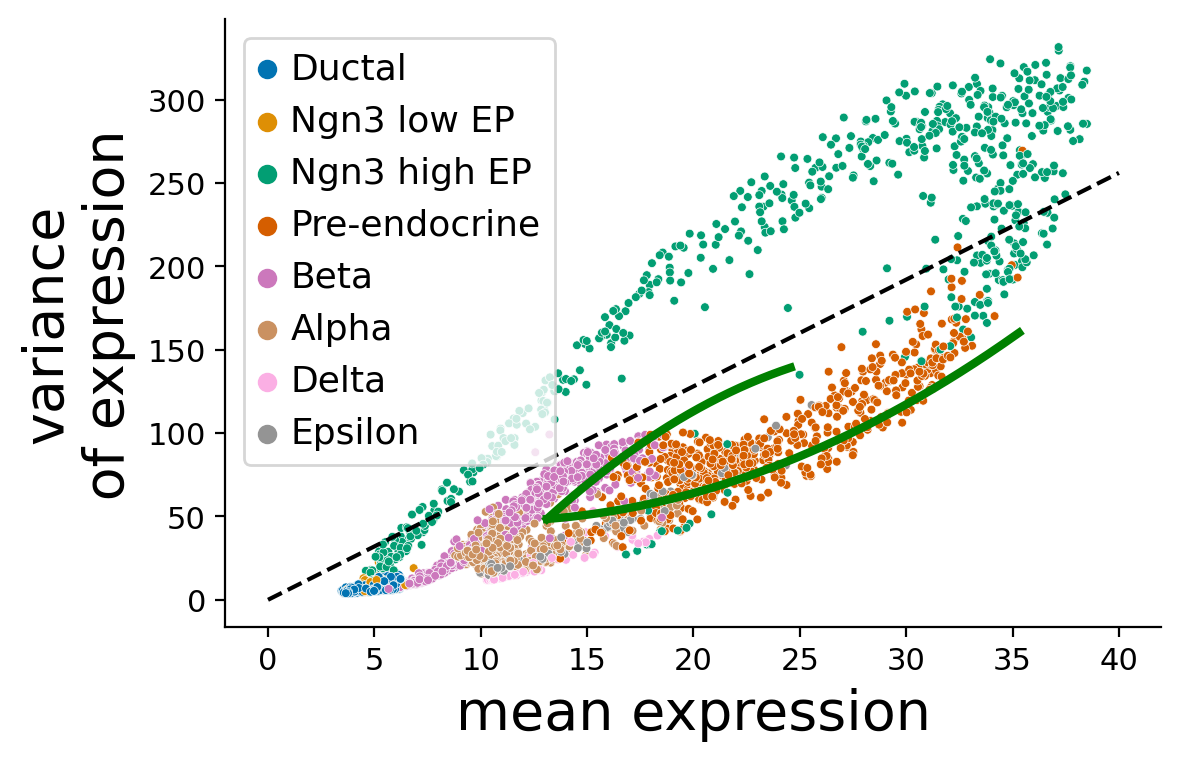

In [96]:
def get_mu_var_time(mu_0, var_0, mu_f, var_f, gamma_, time):
    p_t = np.exp(-gamma_ * time)
    mu_t = mu_0 * p_t + mu_f * (1 - p_t)
    var_t = (var_0 - mu_0) * p_t**2.0 + (var_f - mu_f) * (1 - p_t**2.0) + mu_t
    return mu_t, var_t

gene_ensb = "ENSMUSG00000028161" # Ppp3ca
gene_ = np.where(adata_pan_velo.var_names == gene_ensb)[0][0]
x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
z = adata.obs['clusters'].values.copy()
colrs_ = adata.uns['clusters_colors'].copy()

hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
plt_ = sns.scatterplot(x=x, y=(y), s=10, hue=z, hue_order=hue_order, \
                       palette=col_palette)

time_up_tmp = np.linspace(0, np.max(time_up_gene[:, gene_]), 1000)
mu_up, var_up = \
    get_mu_var_time(mu_0_gene[:, gene_].mean(), var_0_gene[:, gene_].mean(), \
                    mu_up_f_gene[:, gene_].mean(), var_up_f_gene[:, gene_].mean(), \
                    gamma_gene[0, gene_], \
                    time_up_tmp)
plt_ = sns.lineplot(x=mu_up, y=(var_up), color="green", linewidth=3)
time_down_tmp = np.linspace(np.min(time_down_gene[:, gene_]), np.max(time_down_gene[:, gene_]), 1000)
time_down_tmp = np.linspace(0, np.max(time_down_gene[:, gene_]), 1000)
mu_down_gene, var_down_gene = \
    get_mu_var_time(mu_down_up_gene[:, gene_].mean(), var_down_up_gene[:, gene_].mean(), \
                    mu_down_f_gene[:, gene_].mean(), var_down_f_gene[:, gene_].mean(), \
                    gamma_gene[0, gene_], time_down_tmp)
plt_ = sns.lineplot(x=mu_down_gene, y=(var_down_gene), color="green", linewidth=3)

burst_B = var_up_f[0, gene_] / mu_up_f[0, gene_] - 1
max_mean = 40  # Ppp3ca
plt.plot([0, max_mean], [0, max_mean * (burst_B.mean() + 1)], \
            color="black", linestyle="dashed")

plt_.set_xlabel("mean expression", fontsize=20)
plt_.set_ylabel("variance\n of expression", fontsize=20)
plt_.legend(fontsize=13)
sns.despine()

#### For gene Map1b

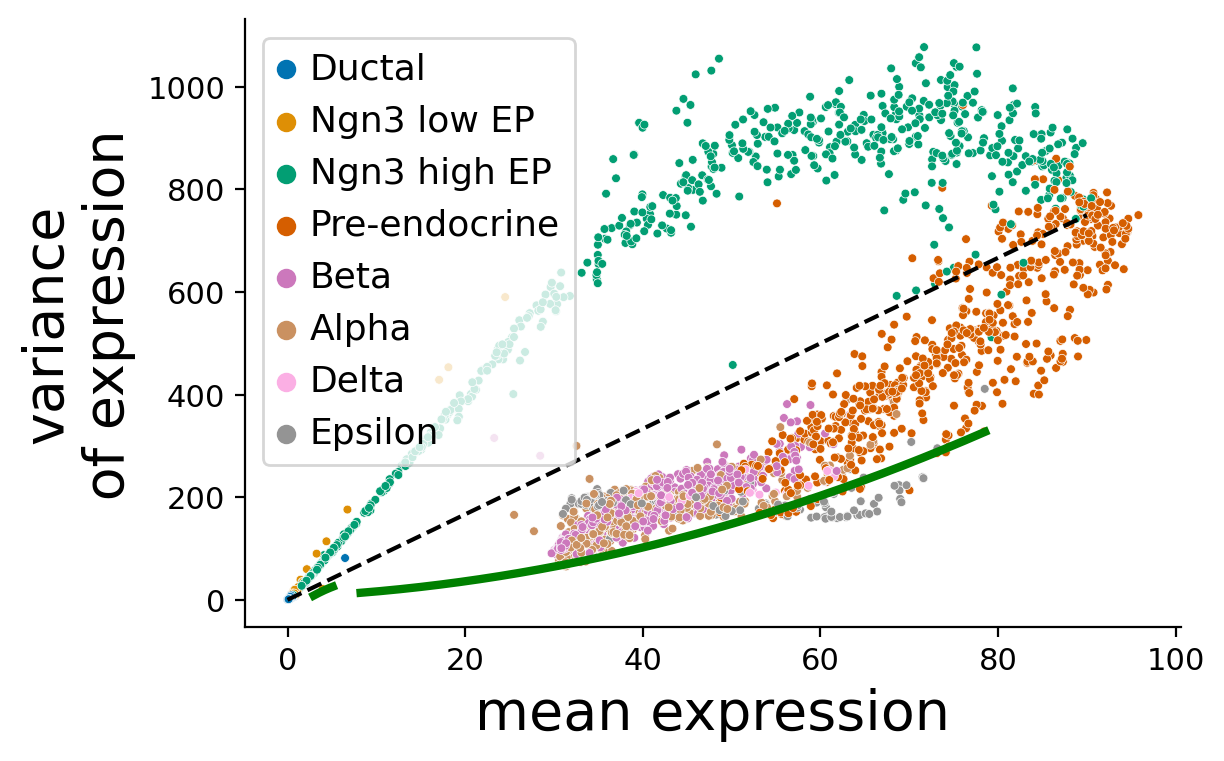

In [97]:
def get_mu_var_time(mu_0, var_0, mu_f, var_f, gamma_, time):
    p_t = np.exp(-gamma_ * time)
    mu_t = mu_0 * p_t + mu_f * (1 - p_t)
    var_t = (var_0 - mu_0) * p_t**2.0 + (var_f - mu_f) * (1 - p_t**2.0) + mu_t
    return mu_t, var_t

gene_ensb = "ENSMUSG00000052727" # Map1b
gene_ = np.where(adata_pan_velo.var_names == gene_ensb)[0][0]
x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
z = adata.obs['clusters'].values.copy()
colrs_ = adata.uns['clusters_colors'].copy()

hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

x = mu_scvi_smooth[:, gene_].copy()
y = var_scvi_smooth[:, gene_].copy()
plt_ = sns.scatterplot(x=x, y=(y), s=10, hue=z, hue_order=hue_order, \
                       palette=col_palette)

time_up_tmp = np.linspace(0, np.max(time_up_gene[:, gene_]), 1000)
mu_up, var_up = \
    get_mu_var_time(mu_0_gene[:, gene_].mean(), var_0_gene[:, gene_].mean(), \
                    mu_up_f_gene[:, gene_].mean(), var_up_f_gene[:, gene_].mean(), \
                    gamma_gene[0, gene_], \
                    time_up_tmp)
plt_ = sns.lineplot(x=mu_up, y=(var_up), color="green", linewidth=3)
time_down_tmp = np.linspace(np.min(time_down_gene[:, gene_]), np.max(time_down_gene[:, gene_]), 1000)
time_down_tmp = np.linspace(0, np.max(time_down_gene[:, gene_]), 1000)
mu_down_gene, var_down_gene = \
    get_mu_var_time(mu_down_up_gene[:, gene_].mean(), var_down_up_gene[:, gene_].mean(), \
                    mu_down_f_gene[:, gene_].mean(), var_down_f_gene[:, gene_].mean(), \
                    gamma_gene[0, gene_], time_down_tmp)
plt_ = sns.lineplot(x=mu_down_gene, y=(var_down_gene), color="green", linewidth=3)

burst_B = var_up_f[0, gene_] / mu_up_f[0, gene_] - 1
max_mean = 90 # Map1b
plt.plot([0, max_mean], [0, max_mean * (burst_B.mean() + 1)], \
            color="black", linestyle="dashed")

plt_.set_xlabel("mean expression", fontsize=20)
plt_.set_ylabel("variance\n of expression", fontsize=20)
plt_.legend(fontsize=13)
sns.despine()

## Compare input mu, var against predicted mu, var from noSpliceVelo
Check correlations and RMSE (normalized)

In [98]:
import scipy
corr_mu_pred = np.zeros((adata_pan_velo.shape[1], 2))
rmse_mu_pred = np.zeros(adata_pan_velo.shape[1])
for gene_ in range(adata_pan_velo.shape[1]):
    x = mu_nosplicevelo[:, gene_].copy()
    y = mu_scvi_smooth[:, gene_].copy()
    tmp = scipy.stats.pearsonr(x, y)
    corr_mu_pred[gene_, 0] = tmp[0]
    corr_mu_pred[gene_, 1] = tmp[1]
    rmse_mu_pred[gene_] = np.sqrt(np.mean((x - y)**2.0)) / np.max(y)

corr_var_pred = np.zeros((adata_pan_velo.shape[1], 2))
rmse_var_pred = np.zeros(adata_pan_velo.shape[1])
for gene_ in range(adata_pan_velo.shape[1]):
    x = var_nosplicevelo[:, gene_].copy()
    y = var_scvi_smooth[:, gene_].copy()
    tmp = scipy.stats.pearsonr(x, y)
    corr_var_pred[gene_, 0] = tmp[0]
    corr_var_pred[gene_, 1] = tmp[1]
    rmse_var_pred[gene_] = np.sqrt(np.mean((x - y)**2.0)) / np.max(y)

0.8503930105318129
0.8087899913732911


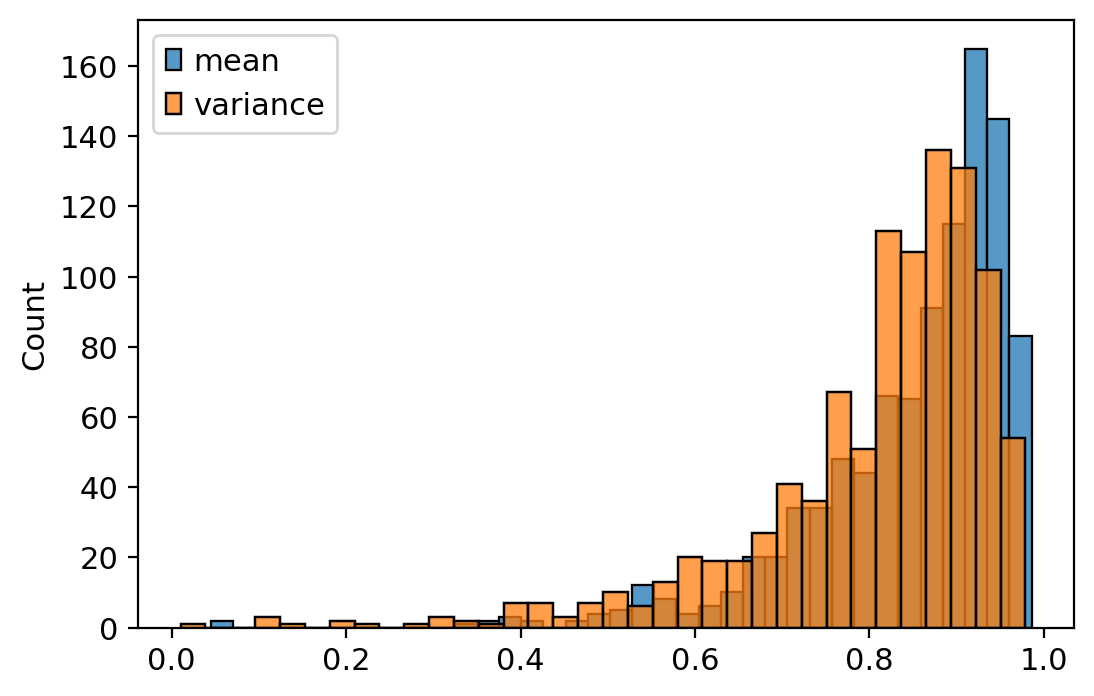

In [99]:
plt_ = sns.histplot(corr_mu_pred[:, 0]**2.0, label="mean")
print(np.mean(corr_mu_pred[:, 0]**2.0))
plt_ = sns.histplot(corr_var_pred[:, 0]**2.0, label="variance")
print(np.mean(corr_var_pred[:, 0]**2.0))

# Show the legend
plt.legend()

0.09619543701410294
0.10318724811077118


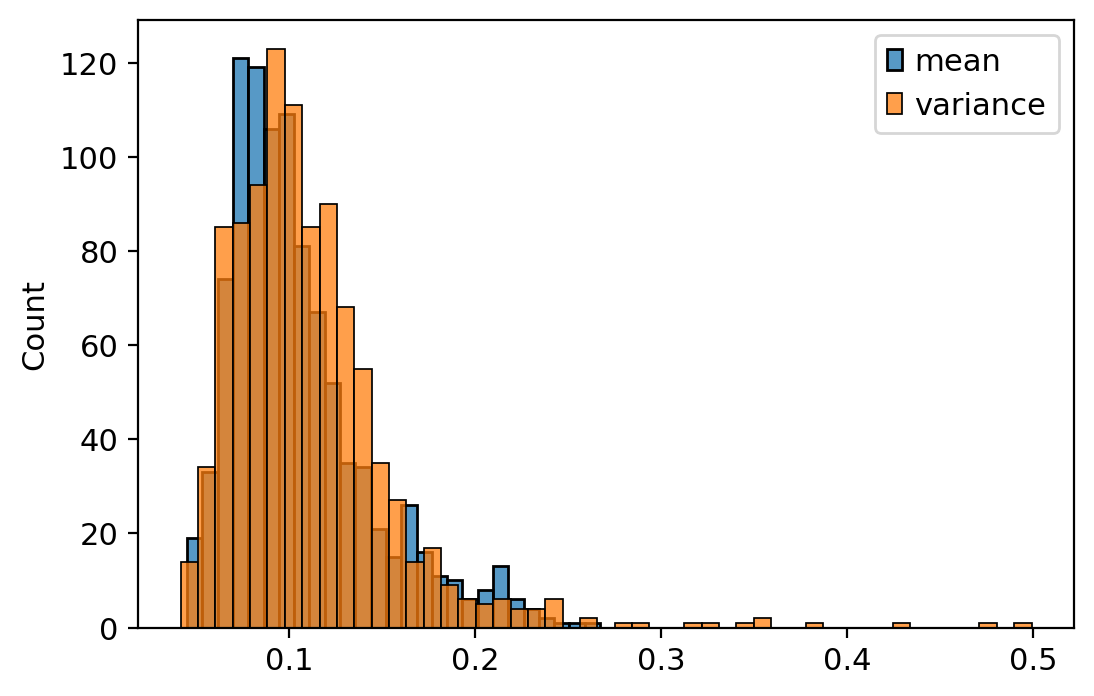

In [100]:
plt_ = sns.histplot(rmse_mu_pred, label="mean")
print(np.median(rmse_mu_pred))
plt_ = sns.histplot(rmse_var_pred, label="variance")
print(np.median(rmse_var_pred))

# Show the legend
plt.legend()

# Perform velocity analysis

## Keep good quality genes

In [101]:
id_gene_ll = np.arange(adata_pan_velo.shape[1])
burst_up_f = var_up_f_gene[0, :] / mu_up_f_gene[0, :]
id_gene_ll = np.where((rmse_mu_pred <= 0.1) & (rmse_var_pred <= 0.1) & \
                      (burst_up_f >= 2))[0]

print(len(id_gene_ll))
adata_pan_tmp = adata_pan_velo[:, id_gene_ll].copy()

991


## get latent representation from noSpliceVelo

In [102]:
adata_pan_tmp.obsm['X_latent'] = model_nosplicevelo.get_latent_representation(give_mean=True)

## get Compute nearest neighbor graph using the latent representation

In [103]:
n_pcs = adata_pan_tmp.obsm['X_latent'].shape[1]
scv.pp.neighbors(adata_pan_tmp, n_pcs=n_pcs, n_neighbors=100, use_rep="X_latent")

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


## Perform UMAP

In [104]:
sc.tl.umap(adata_pan_tmp)

## Save mu, var and their velocities in layer fields in adata_pan_tmp

In [105]:
adata_pan_tmp.layers["velocity_geneCell"] = velo_mu_nosplicevelo[:, id_gene_ll].copy()
adata_pan_tmp.layers["mu_geneCell"] = mu_nosplicevelo[:, id_gene_ll].copy()


adata_pan_tmp.layers["velocity_var_geneCell"] = velo_var_nosplicevelo[:, id_gene_ll].copy()
adata_pan_tmp.layers["var_geneCell"] = var_nosplicevelo[:, id_gene_ll].copy()

In [106]:
adata_pan_tmp.layers["velocity_gene"] = velo_mu_nosplicevelo_gene[:, id_gene_ll].copy()
adata_pan_tmp.layers["mu_gene"] = mu_nosplicevelo_gene[:, id_gene_ll].copy()


adata_pan_tmp.layers["velocity_var_gene"] = velo_var_nosplicevelo_gene[:, id_gene_ll].copy()
adata_pan_tmp.layers["var_gene"] = var_nosplicevelo_gene[:, id_gene_ll].copy()

## Compute velocity graph for mu

In [107]:
import new_velocity_graph
new_velocity_graph.velocity_graph(adata_pan_tmp, xkey="mu_gene", vkey="velocity_gene")

computing velocity graph (using 1/16 cores)
    finished (0:00:07) --> added 
    'velocity_gene_graph', sparse matrix with cosine correlations (adata.uns)


In [108]:
import new_velocity_graph
new_velocity_graph.velocity_graph(adata_pan_tmp, xkey="mu_geneCell", vkey="velocity_geneCell")

computing velocity graph (using 1/16 cores)
    finished (0:00:08) --> added 
    'velocity_geneCell_graph', sparse matrix with cosine correlations (adata.uns)


## Compute velocity graph for var
In this section, we do not directly estimate velocity graph for the variance, we rather use standard deviation and reflected standard deviation

### Get a new object adata_concat
Which contains concatenation of standard deviation and reflected standard deviation

In [109]:
# Extract matrices from two layers (replace 'layer1' and 'layer2' with your actual layer names)
matrix1 = (adata_pan_tmp.layers["mu_geneCell"].copy().astype('float64'))
matrix2 = adata_pan_tmp.layers["var_geneCell"].copy().astype('float64')
matrix1_velo = (adata_pan_tmp.layers["velocity_geneCell"].copy().astype('float64'))
matrix2_velo = adata_pan_tmp.layers["velocity_var_geneCell"].copy().astype('float64')

# Check if the matrices have the same number of rows (cells) before concatenating
if matrix1.shape[0] != matrix2.shape[0]:
    raise ValueError("Matrices must have the same number of rows (cells) for concatenation.")

# Concatenate the matrices along the columns
var_max = np.max(var_scvi_smooth[:, id_gene_ll].copy(), axis=0, keepdims=True) * 5.0
concatenated_matrix_var = np.concatenate((np.sqrt(matrix2), np.sqrt(var_max - matrix2)), axis=1)
matrix_var_velo1 = matrix2_velo / (2 * np.sqrt(matrix2))
matrix_var_velo2 = - matrix2_velo / (2 * np.sqrt(var_max - matrix2))
concatenated_matrix_var_velo = np.concatenate((matrix_var_velo1, matrix_var_velo2), axis=1)

# Create a new AnnData object with the concatenated matrix
adata_concat = ad.AnnData(X=concatenated_matrix_var)
adata_concat.layers['expr_std'] = concatenated_matrix_var.copy()
adata_concat.layers['velocity_std'] = concatenated_matrix_var_velo.copy()
adata_concat.obsm['X_latent'] = adata_pan_tmp.obsm['X_latent'].copy()

### nearest neighbors and UMAP for adata_concat

In [110]:
sc.pp.neighbors(adata_concat, n_neighbors=100, use_rep="X_latent")
sc.tl.umap(adata_concat)

### Get velocity graph for std and its reflection

In [111]:
import new_velocity_graph
# new_velocity_graph.velocity_graph(adata_pan_genes, xkey="Ms", vkey="velocity")
new_velocity_graph.velocity_graph(adata_concat, xkey="expr_std", vkey="velocity_std")

computing velocity graph (using 1/16 cores)
    finished (0:00:13) --> added 
    'velocity_std_graph', sparse matrix with cosine correlations (adata.uns)


## Compute velocity streams

### Velocity stream for mean

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_geneCell_umap1', embedded velocity vectors (adata.obsm)


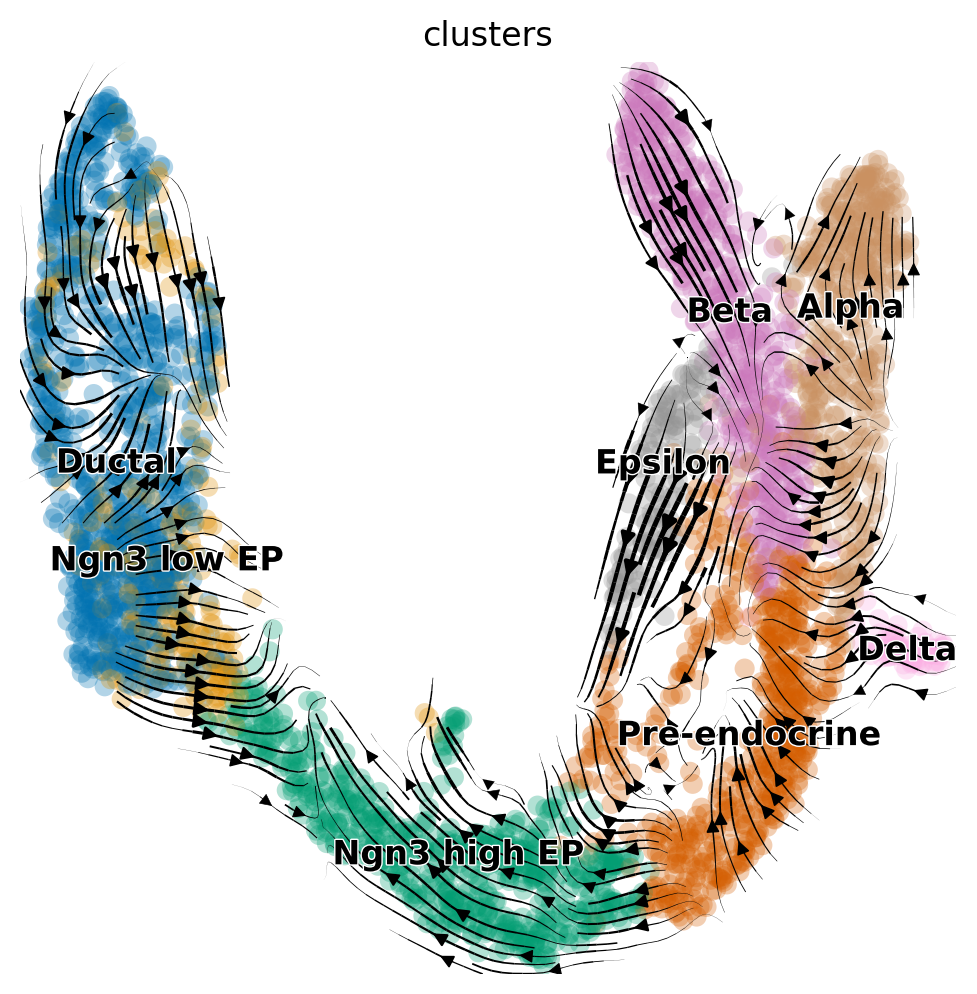

In [112]:
scv.set_figure_params('scvelo')

hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]


import new_velocity_embedding_stream
adata_tmp2 = adata[adata_pan_tmp.obs_names, :].copy()
adata_pan_tmp.obsm['X_umap1'] = adata_tmp2.obsm['X_umap'].copy()
adata_pan_tmp.uns['clusters_colors'] = col_palette.copy()
adata_pan_tmp.obs['clusters'] = adata_tmp2.obs['clusters'].values.copy()
plt_ = new_velocity_embedding_stream.velocity_embedding_stream(adata_pan_tmp, \
                                                        basis='umap1', \
                                                        show=False, \
                                                        figsize=(6, 6), \
                                                        vkey='velocity_geneCell', density=3)

### Velocity stream for std

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_std_umap1', embedded velocity vectors (adata.obsm)


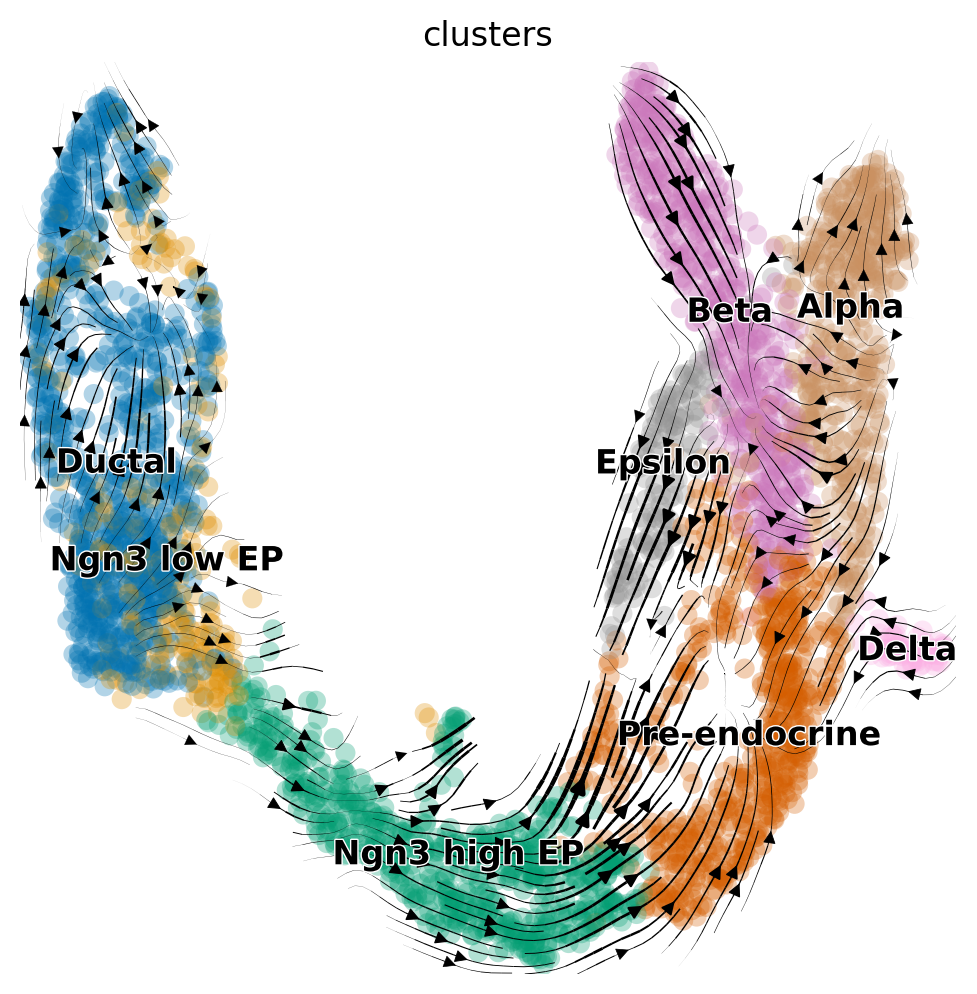

In [113]:
scv.set_figure_params('scvelo')
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]

import new_velocity_embedding_stream
adata_tmp2 = adata[adata_pan_tmp.obs_names, :].copy()
adata_concat.obsm['X_umap1'] = adata_tmp2.obsm['X_umap'].copy()
adata_concat.uns['clusters_colors'] = col_palette.copy()
adata_concat.obs['clusters'] = adata_tmp2.obs['clusters'].values.copy()
plt_ = new_velocity_embedding_stream.velocity_embedding_stream(adata_concat, \
                                                        basis='umap1', \
                                                        show=False, \
                                                        figsize=(6, 6), \
                                                        vkey='velocity_std', density=3)

## Get velocity pseudotime

### velocity pseudotime for mean

computing terminal states
    identified 3 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


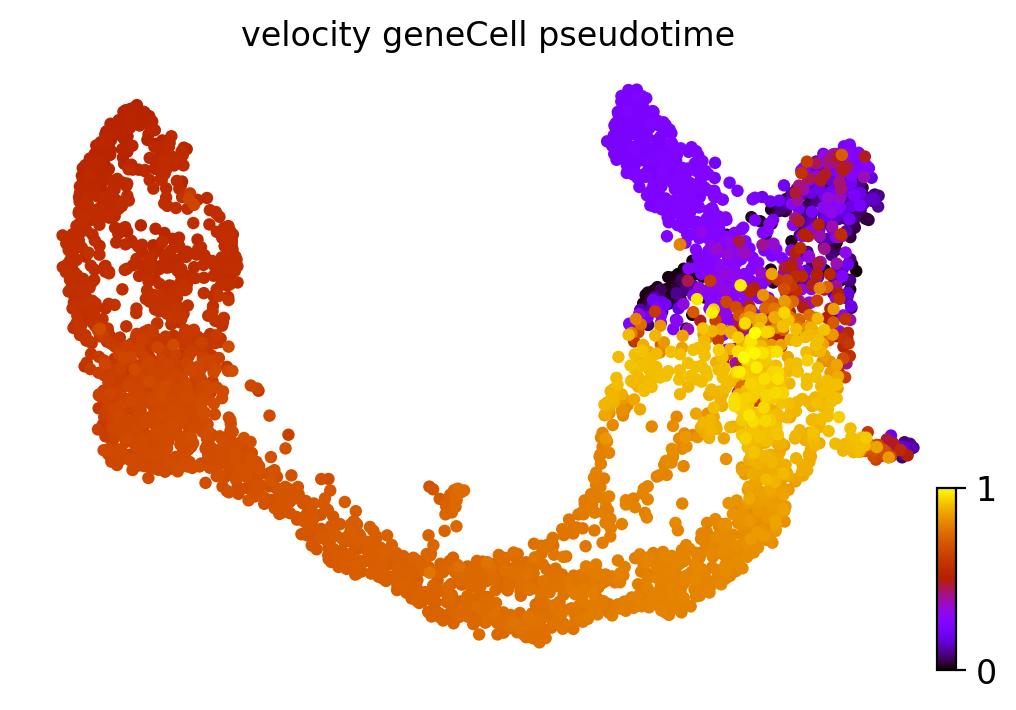

In [76]:
scv.tl.velocity_pseudotime(adata_pan_tmp, \
                           vkey="velocity_geneCell")
scv.pl.scatter(adata_pan_tmp, color='velocity_geneCell_pseudotime', color_map='gnuplot', size=80, \
               basis="umap1")

### velocity pseudotime for std

computing terminal states
    identified 2 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/home/tarunm3/miniconda3/envs/pyg_env/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


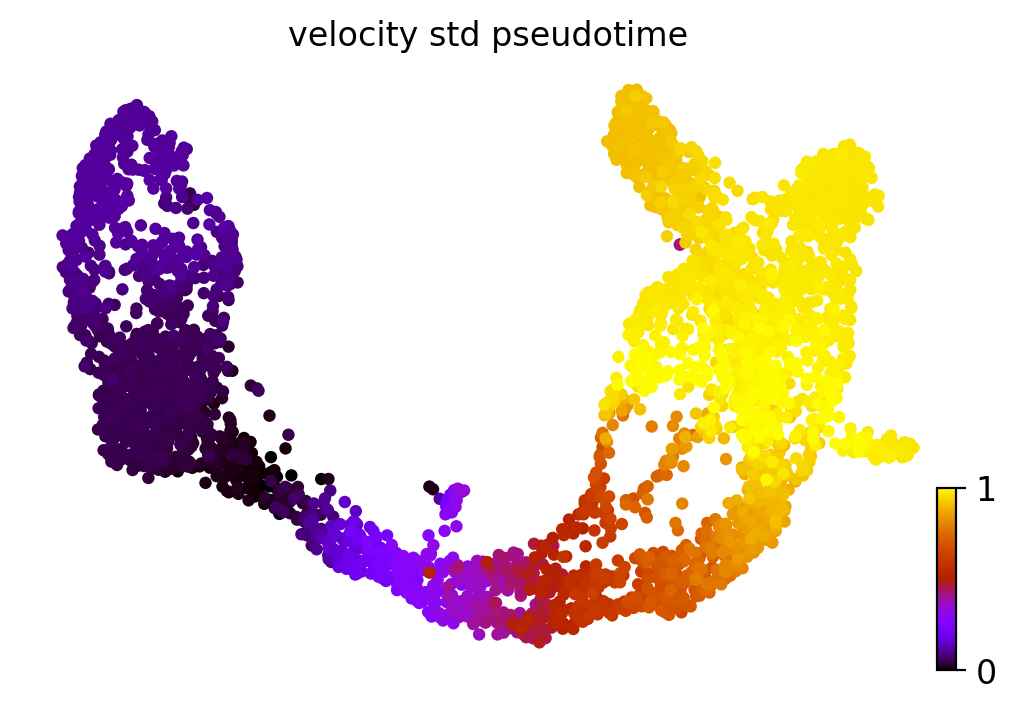

In [78]:
scv.tl.velocity_pseudotime(adata_concat, \
                           vkey="velocity_std")
scv.pl.scatter(adata_concat, color='velocity_std_pseudotime', color_map='gnuplot', size=80, \
               basis="umap1")

## Mean expression vs velocity pseudotime

### Mean expression vs velocity pseudotime for mu

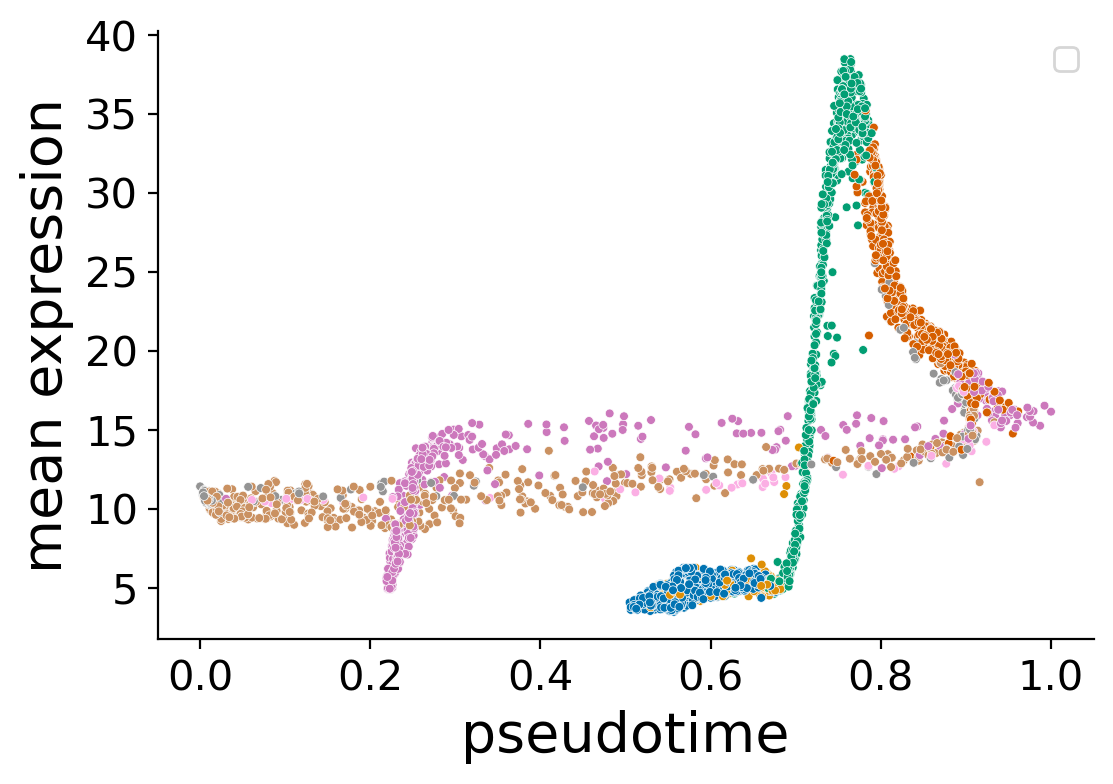

In [81]:
gene_ensb = "ENSMUSG00000028161" # Ppp3ca
gene_ = np.where(adata_pan_tmp.var_names == gene_ensb)[0]
y = adata_pan_tmp.layers['mu'][:, gene_].copy()
x = adata_pan_tmp.obs['velocity_geneCell_pseudotime'].values.copy()
z = adata.obs['clusters'].values.copy()
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
plt_ = sns.scatterplot(x=x.flatten(), y=y.flatten(), hue=z, palette=col_palette, hue_order=hue_order, \
                       s=10, legend=False)
plt_.set_xlabel("pseudotime", fontsize=20)
plt_.set_ylabel("mean expression", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend()
sns.despine()

### Mean expression vs velocity pseudotime for std

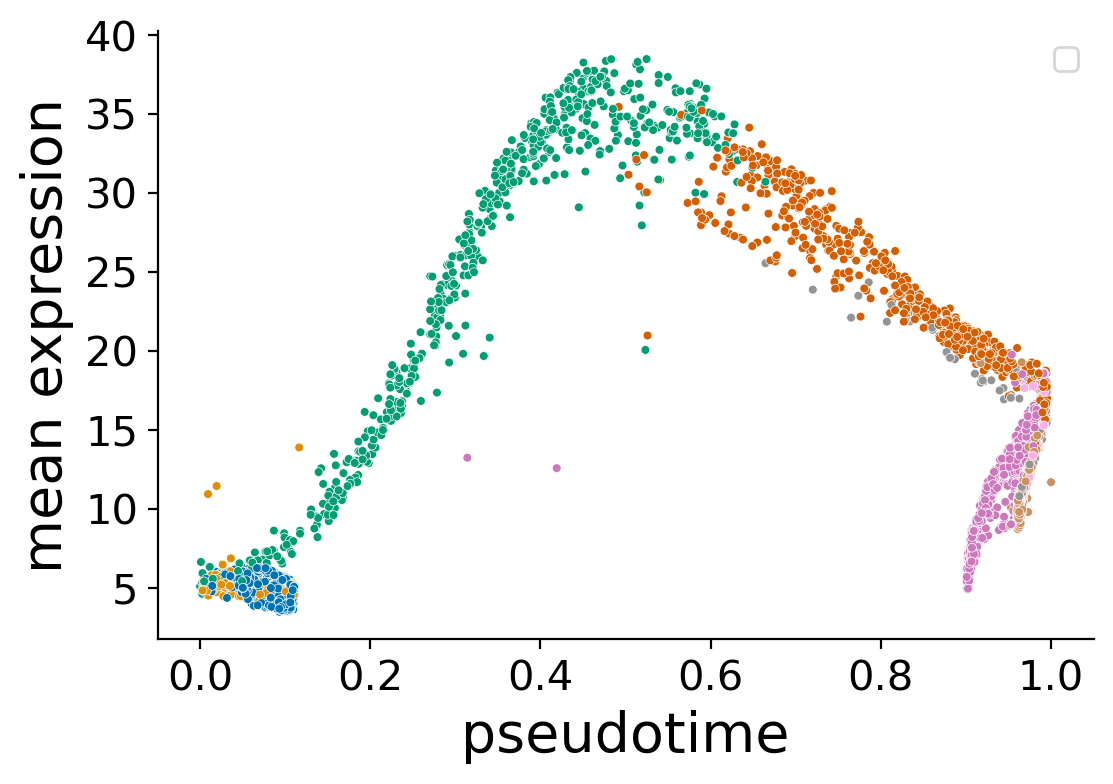

In [84]:
gene_ensb = "ENSMUSG00000028161" # Ppp3ca
gene_ = np.where(adata_pan_tmp.var_names == gene_ensb)[0]
y = adata_pan_tmp.layers['mu'][:, gene_].copy()
x = adata_concat.obs['velocity_std_pseudotime'].values.copy()
z = adata.obs['clusters'].values.copy()
hue_order = ['Ductal', "Ngn3 low EP", "Ngn3 high EP", \
             "Pre-endocrine", "Beta", "Alpha", "Delta", "Epsilon"]
colrs_ = sns.color_palette("colorblind", len(hue_order))
col_palette = {}
for count_, clust_ in enumerate(hue_order):
    col_palette[clust_] = colrs_[count_]
plt_ = sns.scatterplot(x=x.flatten(), y=y.flatten(), hue=z, palette=col_palette, hue_order=hue_order, \
                       s=10, legend=False)
plt_.set_xlabel("pseudotime", fontsize=20)
plt_.set_ylabel("mean expression", fontsize=20)
plt_.set_xticklabels(plt_.get_xticklabels(), fontsize=15)
plt_.set_yticklabels(plt_.get_yticklabels(), fontsize=15)
plt_.legend()
sns.despine()